In [2]:
""" This is graph autoencoder.
The autoencoder is trained taking as input many graphs.
The learned task of the autoencoder is to reconstruct a given molecule. """

import pandas as pd

# Read in the data
drug_data=pd.read_csv("BBBP.csv")

#sum all values equal to 1 in p_np column of drug_data
total_unitary_pnp = sum(drug_data.p_np==1)
print ("Total number of unitary p_np values: ", total_unitary_pnp)

#sum all values equal to 0 in p_np column of drug_data
total_zero_pnp = sum(drug_data.p_np==0)
print ("Total number of zero p_np values: ", total_zero_pnp)

# Print the total number of p_np values
print ("Total number of p_np values: ", len(drug_data.p_np))

# Calculate the percentage of unitary p_np values
print ("Percentage of unitary p_np values: ", round(total_unitary_pnp*100/len(drug_data.p_np),2), "%")

#calculate the percentage of zero p_np values
print ("Percentage of zero p_np values: ", round (total_zero_pnp*100/len(drug_data.p_np),2), "%")



Total number of unitary p_np values:  1567
Total number of zero p_np values:  483
Total number of p_np values:  2050
Percentage of unitary p_np values:  76.44 %
Percentage of zero p_np values:  23.56 %


# Creating images from dataset

In [3]:
from rdkit import Chem
from rdkit import RDLogger
from utils import *
from matplotlib import colors
from rdkit.Chem.Draw import MolToImage

# check the data frame
print(drug_data.head())


#extract smiles from the data frame and check the first 10 smiles
smiles = drug_data['smiles']
smiles.head()

#convert smiles to mols and disable warnings
RDLogger.DisableLog('rdApp.*')
mols = [Chem.MolFromSmiles(s) for s in smiles]
mols
#print (type(mols[0]))

#resizing the drug_data to 
end_of_array = len (drug_data)
smiles=smiles[:end_of_array]
#print(smiles)

for i in range(0, len(smiles)):
    if smiles[i] == None:
        print(i)
# Create a graph representation of the first molecule
for i in range(0, end_of_array):
    name = drug_data['name'][i]
    if mols[i] != None:
        try: img = get_image(mols[i],None , name)
        except : print("un'immagine non è stata salvata")
        

   num                  name  p_np  \
0    1            Propanolol     1   
1    2  Terbutylchlorambucil     1   
2    3                 40730     1   
3    4                    24     1   
4    5           cloxacillin     1   

                                              smiles  
0                   [Cl].CC(C)NCC(O)COc1cccc2ccccc12  
1           C(=O)(OC(C)(C)C)CCCc1ccc(cc1)N(CCCl)CCCl  
2  c12c3c(N4CCN(C)CC4)c(F)cc1c(c(C(O)=O)cn2C(C)CO...  
3                   C1CCN(CC1)Cc1cccc(c1)OCCCNC(=O)C  
4  Cc1onc(c2ccccc2Cl)c1C(=O)N[C@H]3[C@H]4SC(C)(C)...  
un'immagine non è stata salvata
un'immagine non è stata salvata
un'immagine non è stata salvata
un'immagine non è stata salvata
un'immagine non è stata salvata
un'immagine non è stata salvata
un'immagine non è stata salvata
un'immagine non è stata salvata
un'immagine non è stata salvata
un'immagine non è stata salvata
un'immagine non è stata salvata


# Creating the list of the data

In [12]:
from torch_geometric.data import DataLoader
import networkx as nx
from torch_geometric.nn import GAE
from torch_geometric.utils import train_test_split_edges
from utils import *


# Load the smiles and create the graph representation
smiles = drug_data['smiles'].to_list()
# Resize the array
smiles = smiles[:end_of_array]
res = [i for i in range(len(smiles)) if smiles[i] == '']
print (res)
# Load the labels we don't want to use them for training the autoencoder
labels = drug_data['p_np'].to_list()
# Resize the array
labels = labels[:end_of_array]

# Create a list of PyTorch Geometric Data objects
data_list = create_pytorch_geometric_graph_data_list_from_smiles_and_labels(smiles, labels)
print ("First object in the data_list: " + str(data_list[0].x.shape))

[]
First object in the data_list: torch.Size([20, 79])


# Splitting lists of train and tests

In [5]:
# Split the data into training and test sets
import random
random.shuffle(data_list)
print ("Number of graphs in the data_list: " + str(len(data_list)))
print ("Number of graphs in the training set should be: " + str(int(len(data_list)*0.8)))
print ("Number of graphs in the test set should be: " + str(int(len(data_list)*0.2)))
train_len = int(len(data_list)*0.8)
test_len = int(len(data_list)*0.2)
train = data_list[:train_len] #train set
test = data_list[train_len:] #val set
print ("Number of graphs in the training set: " + str(len(train)))
print ("Number of graphs in the test set: " + str(len(test)))

Number of graphs in the data_list: 2039
Number of graphs in the training set should be: 1631
Number of graphs in the test set should be: 407
Number of graphs in the training set: 1631
Number of graphs in the test set: 408


# Creating the dataloader from training data

In [6]:
from torch_geometric.loader import DataLoader
# imposing batch size
batch_size = len(train)
dataloader = DataLoader(dataset=train, batch_size=batch_size)

# Encoder for the GAE

In [7]:
# Defining the model encoder
class GCNEncoder(torch.nn.Module):
    def __init__(self, in_channels, out_channels):
        super(GCNEncoder, self).__init__()
        self.conv1 = GCNConv(in_channels, 2 * out_channels, cached=True) # cached only for transductive learning
        self.conv2 = GCNConv(2 * out_channels, out_channels, cached=True) # cached only for transductive learning
    
    # the forward function defines the computation performed at every call
    def forward(self, x, edge_index):
        x = self.conv1(x, edge_index).relu()
        return self.conv2(x, edge_index)

# GAE model definition

The encoder has to be given as an input for the GAE. The encoder must have a forward function

In [8]:
from torch_geometric.nn import GCNConv, GAE
from torch_geometric.nn import GCNConv, GAE, GATConv, Linear, to_hetero


# parameters for the model
out_channels = 2
print ("The dimension of the output from the encoder part: " + str(out_channels))
num_features = 79
print ("Num of the features: " + str(num_features))

# Create the model
model = GAE(GCNEncoder(num_features, out_channels))


The dimension of the output from the encoder part: 2
Num of the features: 79


# Defining the training part

In [9]:
from torch_geometric.utils import scatter
from torch_geometric.loader import DataLoader
from torch.utils.tensorboard import SummaryWriter

epochs = 1000
print ("Num of the epochs: " + str(epochs))

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

model = model.to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
graph_batch = next(iter(dataloader))

for epoch in range(1, epochs + 1):
   
    # Zero the gradients
    optimizer.zero_grad()
    
    graph_batch = graph_batch.to(device)
    
    batch_size = graph_batch.batch.max().item() + 1
    print ("This is the batch size: " + str(batch_size))
    print (graph_batch)
    out = model.encode(graph_batch.x, graph_batch.edge_index)
    loss = model.recon_loss(out, graph_batch.edge_index)
    
    # Backward pass and optimization
    loss.backward()
    optimizer.step()
    
    # Logging
    if (i + 1) % 10 == 0:
        print("Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}"
            .format(epoch + 1, 100, i + 1, len(dataloader), loss.item()))

Num of the epochs: 1000
This is the batch size: 1631
DataBatch(x=[39064, 79], edge_index=[2, 84250], edge_attr=[84250, 10], y=[1631], batch=[39064], ptr=[1632])
Epoch [2/100], Step [2050/1], Loss: 1.3683
This is the batch size: 1631
DataBatch(x=[39064, 79], edge_index=[2, 84250], edge_attr=[84250, 10], y=[1631], batch=[39064], ptr=[1632])
Epoch [3/100], Step [2050/1], Loss: 1.3579
This is the batch size: 1631
DataBatch(x=[39064, 79], edge_index=[2, 84250], edge_attr=[84250, 10], y=[1631], batch=[39064], ptr=[1632])
Epoch [4/100], Step [2050/1], Loss: 1.3491
This is the batch size: 1631
DataBatch(x=[39064, 79], edge_index=[2, 84250], edge_attr=[84250, 10], y=[1631], batch=[39064], ptr=[1632])
Epoch [5/100], Step [2050/1], Loss: 1.3378
This is the batch size: 1631
DataBatch(x=[39064, 79], edge_index=[2, 84250], edge_attr=[84250, 10], y=[1631], batch=[39064], ptr=[1632])
Epoch [6/100], Step [2050/1], Loss: 1.3244
This is the batch size: 1631
DataBatch(x=[39064, 79], edge_index=[2, 84250],

# Whatching the embedding

The type of Z is: tensor([[ 0.2642, -0.7532],
        [ 0.4697, -1.1487],
        [ 0.2642, -0.7532],
        ...,
        [ 0.9799, -1.0116],
        [ 0.8563, -1.0609],
        [ 0.5541, -0.8183]], grad_fn=<AddBackward0>)
The shape of Z is: torch.Size([39064, 2])


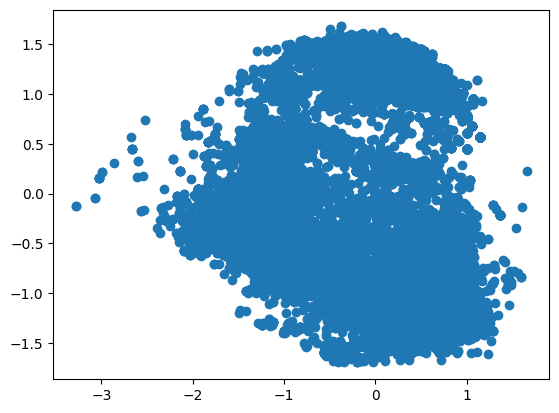

In [10]:
from matplotlib import pyplot as plt
Z= model.encode(graph_batch.x, graph_batch.edge_index)
print ("The type of Z is: " + str(Z))
print ("The shape of Z is: " + str(Z.shape))
plt.plot (Z.detach().numpy()[:,0], Z.detach().numpy()[:,1], 'o')